In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
import random


2025-11-19 10:37:21.215324: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 10:37:21.455449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763545041.553212    1152 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763545041.578799    1152 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763545041.754489    1152 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
import os

base_path = ""
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
valid_path = os.path.join(base_path, "Validation")

#image classes
image_classes = os.listdir("")
image_classes

['Non Defective', 'Defective']

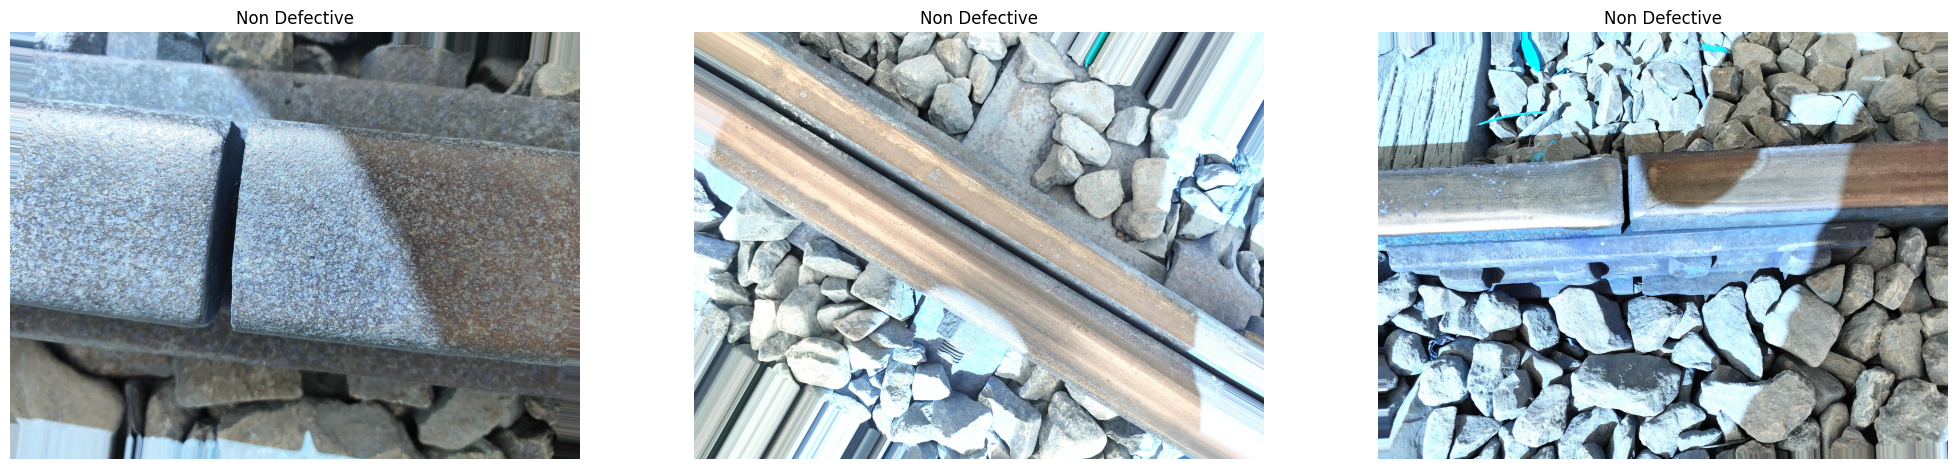

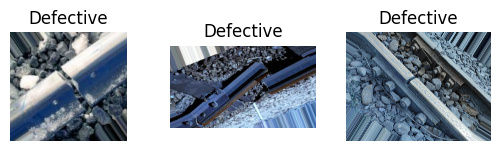

In [3]:
from PIL import Image
def plot_images(image_classes):
    plt.figure(figsize = (25, 25))
    
    for i, category in enumerate(image_classes):
        image_path = train_path + "/" + category
        image_in_folder = os.listdir(image_path)
        
        for j in range(3):
            omage = image_in_folder[j]
            omage_path = image_path + "/" + omage
        
            img = image.load_img(omage_path)
            img_array = image.img_to_array(img) / 255
            
            plt.subplot(3,3, j+1)
            plt.imshow(img_array)
            plt.title(category)
            plt.axis("off")
        plt.show()

plot_images(image_classes)

In [4]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train_data_noaug = image_generator.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size = 32,
                                                class_mode = "categorical")

Found 560 images belonging to 2 classes.


In [6]:
test_data = image_generator.flow_from_directory(test_path,
                                                target_size = (224, 224),
                                                batch_size = 1,
                                                class_mode = "categorical")

Found 80 images belonging to 2 classes.


In [7]:
valid_data = image_generator.flow_from_directory(valid_path,
                                                target_size = (224, 224),
                                                batch_size = 16,
                                                class_mode = "categorical")

Found 158 images belonging to 2 classes.


In [ ]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seed(42)

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

def build_EfficientNetV2B0_model():

    model=EfficientNetV2B0(input_shape=(224,224,3),weights='imagenet',include_top=False)
    model.trainable = False
    x = model.output
    # CLASSIFICATION
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='gelu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='gelu')(x)
    y = Dense(2, activation = "softmax")(x)
    return Model(inputs=model.input, outputs=y)

set_seed(42)
model_noaug = build_EfficientNetV2B0_model()

I0000 00:00:1763545050.622980    1152 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [10]:
model_noaug.compile(optimizer = "adam", 
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])


In [ ]:
# Define the Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose=1,
    restore_best_weights=True
)

In [12]:
model_noaug.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,281,426 (23.96 MB)

 Trainable params: 361,602 (1.38 MB)

 Non-trainable params: 5,919,824 (22.58 MB)

In [13]:
model_history = model_noaug.fit(train_data_noaug, 
                         epochs = 30,
                         validation_data = valid_data,
                         callbacks = [early_stopping])
model_noaug.save("EfficientNetV2B0_trained_with_Rail_Only.keras")


/home/jasser/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1763545063.977447    1370 cuda_dnn.cc:529] Loaded cuDNN version 91002


18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7436 - loss: 0.5657 - val_accuracy: 0.8861 - val_loss: 0.3207
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9379 - loss: 0.1538 - val_accuracy: 0.9177 - val_loss: 0.2253
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9688 - loss: 0.0854 - val_accuracy: 0.9114 - val_loss: 0.2090
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9659 - loss: 0.0897 - val_accuracy: 0.9430 - val_loss: 0.1547
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9716 - loss: 0.0740 - val_accuracy: 0.9430 - val_loss: 0.1370
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9801 - loss: 0.0420 - val_accuracy: 0.9494 - val_loss: 0.1154
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9819 - loss: 0.0365 - val_accuracy: 0.9494 - val_loss: 0.1170
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9858 - loss: 0.0375 - val_accuracy: 0.9557 - val_loss: 0.1015
Epo

In [14]:
model_noaug.evaluate(test_data)

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9508 - loss: 0.1495


[0.18395039439201355, 0.949999988079071]

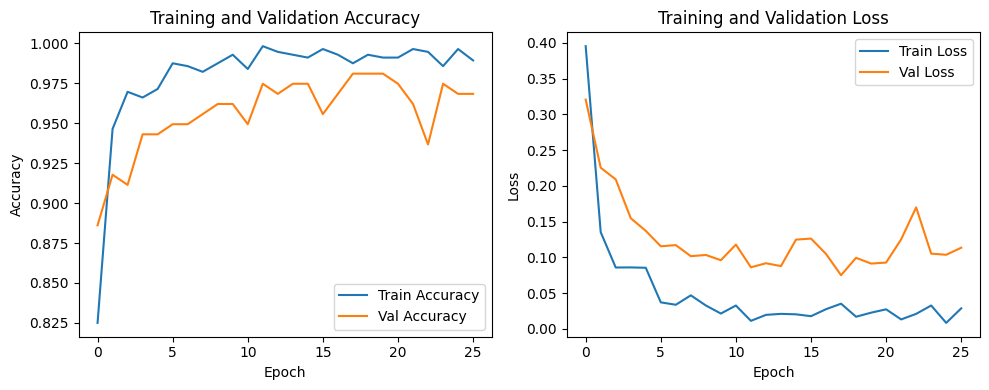

In [15]:
plt.figure(figsize=(10,4))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 80 images belonging to 2 classes.


/home/jasser/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


📊 Classification Report:

               precision    recall  f1-score   support

    Defective       0.91      1.00      0.95        40
Non Defective       1.00      0.90      0.95        40

     accuracy                           0.95        80
    macro avg       0.95      0.95      0.95        80
 weighted avg       0.95      0.95      0.95        80



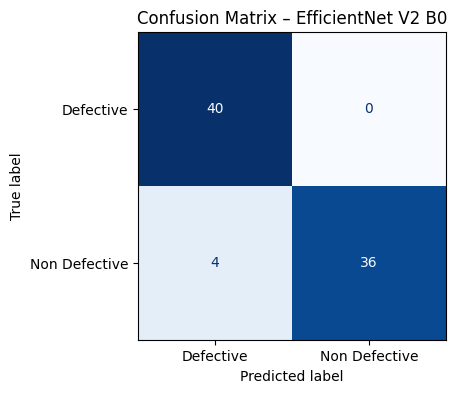

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

test_data = image_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

test_data.reset()

pred_probs = model_noaug.predict(test_data, verbose=0)

y_pred = np.argmax(pred_probs, axis=1)
y_true = test_data.classes

target_names = list(test_data.class_indices.keys())
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names
)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title('Confusion Matrix – EfficientNet V2 B0')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
model_ft_test = load_model("EfficientNetV2B0_trained_with_Rail_Only.keras")

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [23]:
for layer in model_ft_test.layers[::-1]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print("Last Conv Layer:", layer.name)
        break


Last Conv Layer: top_conv


/home/jasser/.local/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


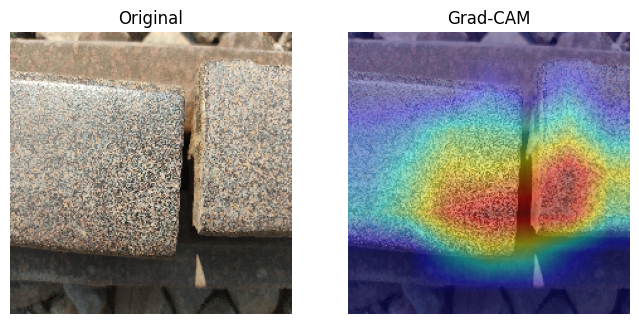

In [ ]:
img_path = test_data.filepaths[2]

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
img_array = preprocess_input(img_array)

heatmap = make_gradcam_heatmap(img_array, model_ft_test, last_conv_layer_name="top_conv")
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 
                                   0.6, heatmap, 0.4, 0)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis("off")
plt.show()
